In [1]:
!pip install haversine

In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from haversine import haversine
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import LearningCurveDisplay

In [4]:
from google.cloud import bigquery

In [5]:
client = bigquery.Client()

In [6]:

query = """
SELECT
          *
        FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE
            pickup_latitude IS NOT NULL
            AND pickup_longitude IS NOT NULL
            AND dropoff_latitude IS NOT NULL
            AND dropoff_longitude IS NOT NULL
            AND pickup_census_tract IS NOT NULL
            AND dropoff_census_tract IS NOT NULL
            AND fare IS NOT NULL
            AND pickup_community_area IS NOT NULL
            AND dropoff_community_area IS NOT NULL
        LIMIT 20000
"""


In [7]:
df = client.query(query).result().to_dataframe()
df

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,6e3805494f154e878aaa1d1e4f4b9607155437bc,b2b3941b38fad492b956dc4ec546dab16697d7071bcb02...,2018-10-26 18:45:00+00:00,2018-10-26 19:00:00+00:00,300,0.7,17031080201,17031081100,8,8,...,0.0,5.50,Cash,Taxi Affiliation Services,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967)
1,c92b6caaa4711acf4b585d6962de26c757c2625c,c037f72571661a73d9cd7575374482ec91c4ca9ec869d0...,2018-10-18 22:15:00+00:00,2018-10-18 22:30:00+00:00,480,1.4,17031071500,17031081500,7,8,...,1.0,8.25,Cash,Star North Management LLC,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
2,284c05d67d3920e5fc53b8758eba06e4e87305ab,282f6fefb5261b5b2642a9b4702b76641a0badbd14f304...,2018-10-26 09:30:00+00:00,2018-10-26 09:45:00+00:00,1020,2.8,17031071300,17031839100,7,32,...,0.0,15.25,Credit Card,Taxi Affiliation Services,41.921778,-87.641460,POINT (-87.6414597588 41.9217783562),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
3,72065f51ea9783ed9423d515de2179c1c3344473,1eaf50df810f85b1dbcb7a12f35850df23a34ff48380a6...,2018-10-18 20:30:00+00:00,2018-10-18 20:45:00+00:00,1020,0.0,17031161000,17031031400,16,3,...,0.0,17.10,Credit Card,Taxi Affiliation Services,41.949974,-87.730684,POINT (-87.7306842554 41.9499744545),41.962179,-87.645379,POINT (-87.6453787624 41.962178629)
4,8a643b9e55967ac19e19297d3f330eea4f699780,768431d476300aa4759020069a99c25201a9ce1c21e94e...,2018-10-19 14:30:00+00:00,2018-10-19 14:45:00+00:00,1020,0.1,17031080300,17031280100,8,28,...,1.0,14.10,Credit Card,Blue Ribbon Taxi Association Inc.,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,104e561a22bce892b1ffa475cf0cfb7df0a301b0,c0250f358cae01c5319aeb7b39827e53f9a2259eb32e4c...,2018-10-24 10:00:00+00:00,2018-10-24 10:15:00+00:00,660,0.0,17031280100,17031320100,28,32,...,0.0,9.75,Credit Card,Blue Ribbon Taxi Association Inc.,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
19996,ab8cebde46617ae30037310f2502d49da8a5f101,f1c4fb891f4812fb2865e801d2185b401283b34401b71f...,2018-10-19 09:00:00+00:00,2018-10-19 09:00:00+00:00,0,0.0,17031280100,17031280100,28,28,...,0.0,3.25,Cash,Taxi Affiliation Services,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224)
19997,174b1996d1e5fcbd90b9341b15f966b584ca7122,d5a39ffd1a6f7f670ef5196342c025b9ad62aa127b8f56...,2018-10-26 14:15:00+00:00,2018-10-26 14:30:00+00:00,1200,0.3,17031280100,17031063200,28,6,...,0.0,18.50,Credit Card,Blue Ribbon Taxi Association Inc.,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.938391,-87.638575,POINT (-87.6385749205 41.938391257700005)
19998,0219cedda2b5649654e4134c3ffbcb1f2f1a33ad,cbdd490649df25aa771979bed8930b199d27a990ccdb42...,2018-10-26 16:30:00+00:00,2018-10-26 16:30:00+00:00,420,1.2,17031280100,17031081600,28,8,...,0.0,8.75,Credit Card,Star North Management LLC,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347)


In [8]:
df.shape

(20000, 23)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              20000 non-null  object             
 1   taxi_id                 20000 non-null  object             
 2   trip_start_timestamp    20000 non-null  datetime64[ns, UTC]
 3   trip_end_timestamp      20000 non-null  datetime64[ns, UTC]
 4   trip_seconds            20000 non-null  Int64              
 5   trip_miles              20000 non-null  float64            
 6   pickup_census_tract     20000 non-null  Int64              
 7   dropoff_census_tract    20000 non-null  Int64              
 8   pickup_community_area   20000 non-null  Int64              
 9   dropoff_community_area  20000 non-null  Int64              
 10  fare                    20000 non-null  float64            
 11  tips                    20000 non-null  f

In [10]:
# Convert the datetime column to datetime dtype
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])

# Convert datetime values to the desired format
df['trip_start_timestamp'] = df['trip_start_timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Convert the datetime column to datetime dtype
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

# Convert datetime values to the desired format
df['trip_end_timestamp'] = df['trip_end_timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [11]:
df.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,6e3805494f154e878aaa1d1e4f4b9607155437bc,b2b3941b38fad492b956dc4ec546dab16697d7071bcb02...,2018-10-26 18:45:00,2018-10-26 19:00:00,300,0.7,17031080201,17031081100,8,8,...,0.0,5.50,Cash,Taxi Affiliation Services,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967)
1,c92b6caaa4711acf4b585d6962de26c757c2625c,c037f72571661a73d9cd7575374482ec91c4ca9ec869d0...,2018-10-18 22:15:00,2018-10-18 22:30:00,480,1.4,17031071500,17031081500,7,8,...,1.0,8.25,Cash,Star North Management LLC,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
2,284c05d67d3920e5fc53b8758eba06e4e87305ab,282f6fefb5261b5b2642a9b4702b76641a0badbd14f304...,2018-10-26 09:30:00,2018-10-26 09:45:00,1020,2.8,17031071300,17031839100,7,32,...,0.0,15.25,Credit Card,Taxi Affiliation Services,41.921778,-87.641460,POINT (-87.6414597588 41.9217783562),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
3,72065f51ea9783ed9423d515de2179c1c3344473,1eaf50df810f85b1dbcb7a12f35850df23a34ff48380a6...,2018-10-18 20:30:00,2018-10-18 20:45:00,1020,0.0,17031161000,17031031400,16,3,...,0.0,17.10,Credit Card,Taxi Affiliation Services,41.949974,-87.730684,POINT (-87.7306842554 41.9499744545),41.962179,-87.645379,POINT (-87.6453787624 41.962178629)
4,8a643b9e55967ac19e19297d3f330eea4f699780,768431d476300aa4759020069a99c25201a9ce1c21e94e...,2018-10-19 14:30:00,2018-10-19 14:45:00,1020,0.1,17031080300,17031280100,8,28,...,1.0,14.10,Credit Card,Blue Ribbon Taxi Association Inc.,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224)


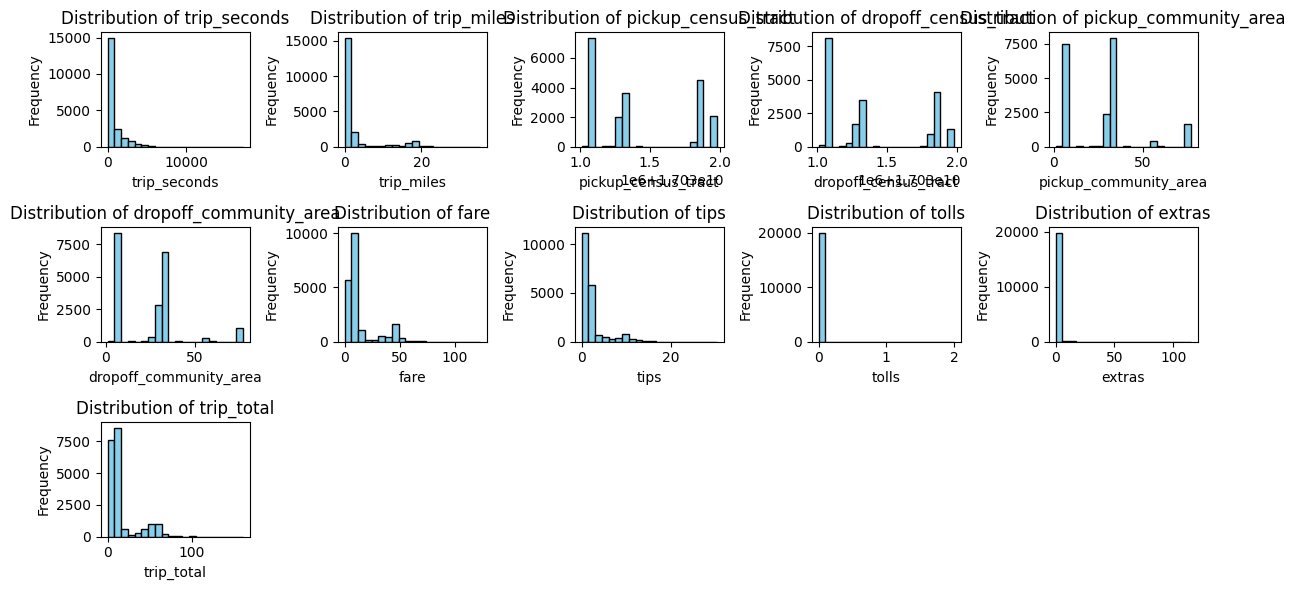

In [12]:
test_df = df
test_df.fillna(0, inplace=True)

features = ['trip_seconds', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras', 'trip_total']

num_features = len(features)
num_cols = 5
num_rows = (num_features - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, feature in enumerate(features):
    row_index = i // num_cols
    col_index = i % num_cols

    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]

    ax.hist(df[feature], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for i in range(num_features, num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.show()

In [13]:
# code ini diambil dari kaggle dan dimodifikasi
# Yang dimodifikasi: Census tract tidak di drop
to_drop = ["taxi_id",
           "tips",
           "trip_seconds",
           "trip_miles",
           "extras",
           "trip_total",
           "company",
           "tolls",
           "payment_type",
           "trip_end_timestamp"]

# Drop selected fields in place
df.drop(to_drop, inplace=True, axis=1)

In [14]:
df.head()

,unique_key,trip_start_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,6e3805494f154e878aaa1d1e4f4b9607155437bc,2018-10-26 18:45:00,17031080201,17031081100,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967)
1,c92b6caaa4711acf4b585d6962de26c757c2625c,2018-10-18 22:15:00,17031071500,17031081500,7,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
2,284c05d67d3920e5fc53b8758eba06e4e87305ab,2018-10-26 09:30:00,17031071300,17031839100,7,32,11.75,41.921778,-87.641460,POINT (-87.6414597588 41.9217783562),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
3,72065f51ea9783ed9423d515de2179c1c3344473,2018-10-18 20:30:00,17031161000,17031031400,16,3,14.25,41.949974,-87.730684,POINT (-87.7306842554 41.9499744545),41.962179,-87.645379,POINT (-87.6453787624 41.962178629)
4,8a643b9e55967ac19e19297d3f330eea4f699780,2018-10-19 14:30:00,17031080300,17031280100,8,28,10.75,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   unique_key              20000 non-null  object 
 1   trip_start_timestamp    20000 non-null  object 
 2   pickup_census_tract     20000 non-null  Int64  
 3   dropoff_census_tract    20000 non-null  Int64  
 4   pickup_community_area   20000 non-null  Int64  
 5   dropoff_community_area  20000 non-null  Int64  
 6   fare                    20000 non-null  float64
 7   pickup_latitude         20000 non-null  float64
 8   pickup_longitude        20000 non-null  float64
 9   pickup_location         20000 non-null  object 
 10  dropoff_latitude        20000 non-null  float64
 11  dropoff_longitude       20000 non-null  float64
 12  dropoff_location        20000 non-null  object 
dtypes: Int64(4), float64(5), object(4)
memory usage: 2.1+ MB


In [16]:
df.drop(columns=['unique_key'], inplace=True, axis=1)
df.head()

,trip_start_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,2018-10-26 18:45:00,17031080201,17031081100,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967)
1,2018-10-18 22:15:00,17031071500,17031081500,7,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
2,2018-10-26 09:30:00,17031071300,17031839100,7,32,11.75,41.921778,-87.641460,POINT (-87.6414597588 41.9217783562),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
3,2018-10-18 20:30:00,17031161000,17031031400,16,3,14.25,41.949974,-87.730684,POINT (-87.7306842554 41.9499744545),41.962179,-87.645379,POINT (-87.6453787624 41.962178629)
4,2018-10-19 14:30:00,17031080300,17031280100,8,28,10.75,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224)


In [17]:
# code ini diambil dari kaggle dan dimodifikasi
# Yang dimodifikasi: trip_start_timestamp diubah kedalam datetime terlebih dahulu
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['weekday'] = df['trip_start_timestamp'].map(lambda x: x.weekday())
df['time'] = df['trip_start_timestamp'].map(lambda x: x.hour*4 + round(x.minute/15))

df.head()

,trip_start_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,weekday,time
0,2018-10-26 18:45:00,17031080201,17031081100,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),4,75
1,2018-10-18 22:15:00,17031071500,17031081500,7,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),3,89
2,2018-10-26 09:30:00,17031071300,17031839100,7,32,11.75,41.921778,-87.641460,POINT (-87.6414597588 41.9217783562),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),4,38
3,2018-10-18 20:30:00,17031161000,17031031400,16,3,14.25,41.949974,-87.730684,POINT (-87.7306842554 41.9499744545),41.962179,-87.645379,POINT (-87.6453787624 41.962178629),3,82
4,2018-10-19 14:30:00,17031080300,17031280100,8,28,10.75,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),4,58


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_census_tract     20000 non-null  Int64         
 2   dropoff_census_tract    20000 non-null  Int64         
 3   pickup_community_area   20000 non-null  Int64         
 4   dropoff_community_area  20000 non-null  Int64         
 5   fare                    20000 non-null  float64       
 6   pickup_latitude         20000 non-null  float64       
 7   pickup_longitude        20000 non-null  float64       
 8   pickup_location         20000 non-null  object        
 9   dropoff_latitude        20000 non-null  float64       
 10  dropoff_longitude       20000 non-null  float64       
 11  dropoff_location        20000 non-null  object        
 12  weekday                 20000 non-null  int64 

In [19]:
df

,trip_start_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,weekday,time
0,2018-10-26 18:45:00,17031080201,17031081100,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),4,75
1,2018-10-18 22:15:00,17031071500,17031081500,7,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),3,89
2,2018-10-26 09:30:00,17031071300,17031839100,7,32,11.75,41.921778,-87.641460,POINT (-87.6414597588 41.9217783562),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),4,38
3,2018-10-18 20:30:00,17031161000,17031031400,16,3,14.25,41.949974,-87.730684,POINT (-87.7306842554 41.9499744545),41.962179,-87.645379,POINT (-87.6453787624 41.962178629),3,82
4,2018-10-19 14:30:00,17031080300,17031280100,8,28,10.75,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),4,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2018-10-24 10:00:00,17031280100,17031320100,28,32,7.75,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),2,40
19996,2018-10-19 09:00:00,17031280100,17031280100,28,28,3.25,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),4,36
19997,2018-10-26 14:15:00,17031280100,17031063200,28,6,16.50,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.938391,-87.638575,POINT (-87.6385749205 41.938391257700005),4,57
19998,2018-10-26 16:30:00,17031280100,17031081600,28,8,6.75,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),4,66


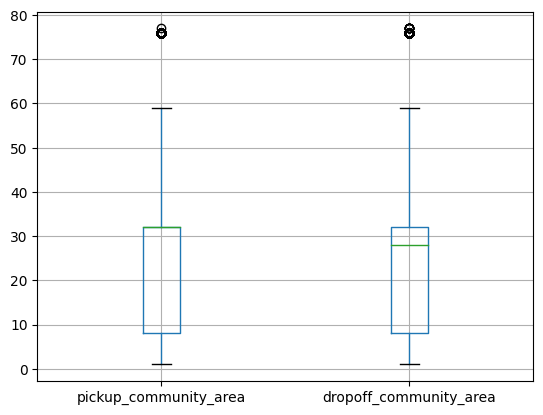

In [21]:
boxplot = df.boxplot(column=['pickup_community_area','dropoff_community_area'])

In [22]:
df.dropna(inplace=True)
df.shape

(20000, 14)

In [23]:
# Calculate the median
median_pickup = df['pickup_community_area'].median()
median_dropoff = df['dropoff_community_area'].median()

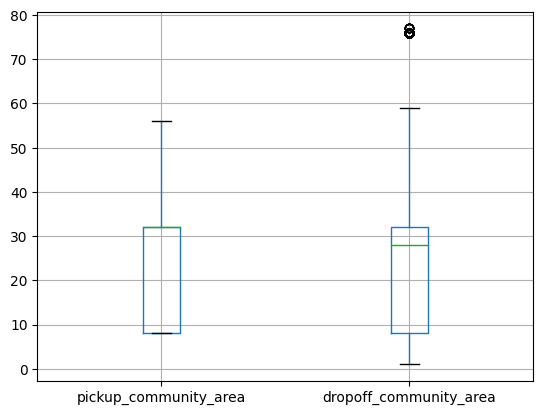

In [24]:
# Winsorization for pickup_community_area
data_pickup = df['pickup_community_area']
lower_limit_pickup = np.percentile(data_pickup, 5)  
upper_limit_pickup = np.percentile(data_pickup, 90)  

df['pickup_community_area'] = np.where((data_pickup < lower_limit_pickup) | (data_pickup > upper_limit_pickup), median_pickup, data_pickup)
df['pickup_community_area'] = df['pickup_community_area'].astype(int)

# Updated boxplot with outliers replaced by median
updated_boxplot = df.boxplot(column=['pickup_community_area', 'dropoff_community_area'])

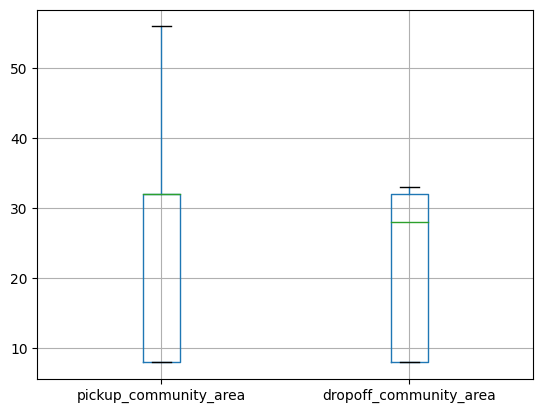

In [25]:
# Winsorization for dropoff_community_area
data_dropoff = df['dropoff_community_area']
lower_limit_dropoff = np.percentile(data_dropoff, 5)  
upper_limit_dropoff = np.percentile(data_dropoff, 90)  

df['dropoff_community_area'] = np.where((data_dropoff < lower_limit_dropoff) | (data_dropoff > upper_limit_dropoff), median_dropoff, data_dropoff)
df['dropoff_community_area'] = df['dropoff_community_area'].astype(int)
# Updated boxplot with outliers replaced by median
updated_boxplot = df.boxplot(column=['pickup_community_area', 'dropoff_community_area'])

In [26]:
def calculate_distance(row):
    return haversine((row['pickup_latitude'], row['pickup_longitude']),
                      (row['dropoff_latitude'], row['dropoff_longitude']),
                      unit='m')

# Generate lineal distance field
df['distance'] = df.apply(calculate_distance, axis=1)

In [27]:
df.head()

,trip_start_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,weekday,time,distance
0,2018-10-26 18:45:00,17031080201,17031081100,8,8,5.50,41.909496,-87.630964,POINT (-87.630963601 41.9094956686),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),4,75,1042.669793
1,2018-10-18 22:15:00,17031071500,17031081500,32,8,7.25,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),3,89,2500.177813
2,2018-10-26 09:30:00,17031071300,17031839100,32,32,11.75,41.921778,-87.641460,POINT (-87.6414597588 41.9217783562),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),4,38,4591.944450
3,2018-10-18 20:30:00,17031161000,17031031400,16,28,14.25,41.949974,-87.730684,POINT (-87.7306842554 41.9499744545),41.962179,-87.645379,POINT (-87.6453787624 41.962178629),3,82,7183.349289
4,2018-10-19 14:30:00,17031080300,17031280100,8,28,10.75,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),4,58,2535.653490


In [28]:
df.drop(columns=(['pickup_location', 'dropoff_location']), inplace=True, axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_census_tract     20000 non-null  Int64         
 2   dropoff_census_tract    20000 non-null  Int64         
 3   pickup_community_area   20000 non-null  int64         
 4   dropoff_community_area  20000 non-null  int64         
 5   fare                    20000 non-null  float64       
 6   pickup_latitude         20000 non-null  float64       
 7   pickup_longitude        20000 non-null  float64       
 8   dropoff_latitude        20000 non-null  float64       
 9   dropoff_longitude       20000 non-null  float64       
 10  weekday                 20000 non-null  int64         
 11  time                    20000 non-null  int64         
 12  distance                20000 non-null  float6

In [30]:
df.drop(columns=(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']), inplace=True, axis=1)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_census_tract     20000 non-null  Int64         
 2   dropoff_census_tract    20000 non-null  Int64         
 3   pickup_community_area   20000 non-null  int64         
 4   dropoff_community_area  20000 non-null  int64         
 5   fare                    20000 non-null  float64       
 6   weekday                 20000 non-null  int64         
 7   time                    20000 non-null  int64         
 8   distance                20000 non-null  float64       
dtypes: Int64(2), datetime64[ns](1), float64(2), int64(4)
memory usage: 1.4 MB


In [32]:
df.drop('trip_start_timestamp', inplace=True, axis=1)

X = df.drop('fare', axis=1)
y = df['fare']
y = np.asarray(y, dtype=np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

In [34]:
y_pred_rf = rf.predict(X_test).flatten()

In [35]:
df_test_rf = pd.DataFrame(data={"Actual test":y_test, "Prediction":y_pred_rf})
df_test_rf

,Actual test,Prediction
0,8.50,9.342917
1,9.00,8.863750
2,4.75,6.541103
3,6.50,5.433679
4,5.25,6.906250
...,...,...
3995,10.75,11.343917
3996,7.25,8.165375
3997,7.75,6.972500
3998,7.00,6.451393


In [36]:
mse = mean_squared_error(y_pred_rf, y_test)
rmse = root_mean_squared_error(y_pred_rf, y_test)
mae = mean_absolute_error(y_pred_rf, y_test)
mape = mean_absolute_percentage_error(y_pred_rf, y_test)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MSE: 12.448670392587964
RMSE: 3.5282673357595744
MAE: 1.463672710831544
MAPE: 0.16019736498819873


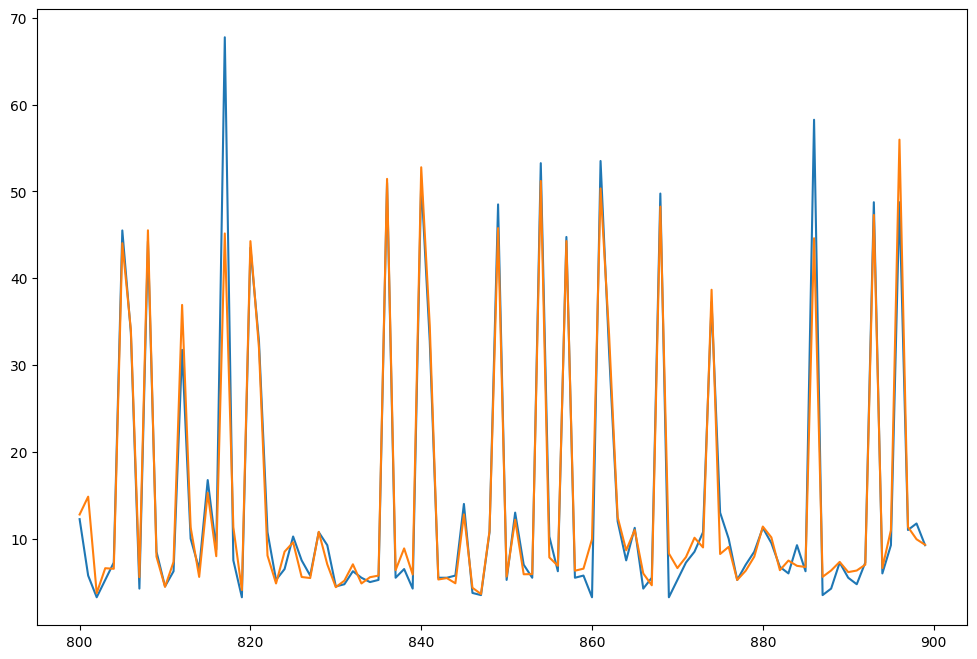

In [37]:
plt.figure(figsize=(12,8))
plt.plot(df_test_rf['Actual test'][800:900], label="A. Test")
plt.plot(df_test_rf['Prediction'][800:900], label="prediction")
plt.show()

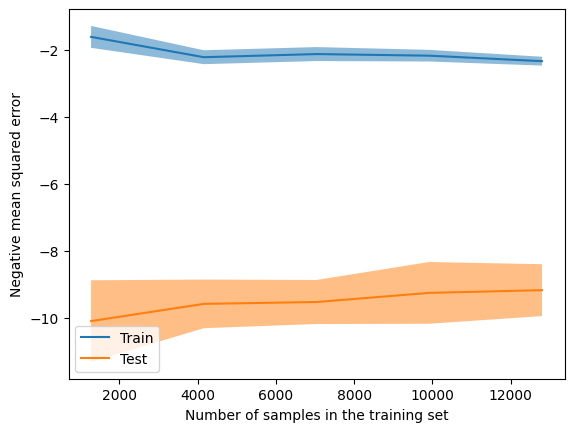

In [38]:
LearningCurveDisplay.from_estimator(rf, X_train, y_train, scoring = 'neg_mean_squared_error')
plt.show()

In [39]:
from sklearn.model_selection import GridSearchCV
import joblib

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_model = GridSearchCV(rf, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=None, verbose=1, n_jobs=-1)

with joblib.parallel_backend('threading', n_jobs=-1):
    rf_model.fit(X_train, y_train)

best_params = rf_model.best_params_
rf_model_tuned = RandomForestRegressor(**best_params)
rf_model_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=5,
                      n_estimators=200)

In [40]:
rf_model_tuned_pred = rf_model_tuned.predict(X_test).flatten()
mse = mean_squared_error(rf_model_tuned_pred, y_test)
rmse = root_mean_squared_error(rf_model_tuned_pred, y_test)
mae = mean_absolute_error(rf_model_tuned_pred, y_test)
mape = mean_absolute_percentage_error(rf_model_tuned_pred, y_test)


print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MSE: 10.94264572957062
RMSE: 3.30796700853721
MAE: 1.376689147672212
MAPE: 0.14861915907800666


In [41]:
df_test_tuned_rf = pd.DataFrame(data={"Actual test":y_test, "Prediction":rf_model_tuned_pred})
df_test_tuned_rf

,Actual test,Prediction
0,8.50,8.332665
1,9.00,8.527604
2,4.75,6.311021
3,6.50,5.997308
4,5.25,6.037238
...,...,...
3995,10.75,11.382673
3996,7.25,6.971484
3997,7.75,6.953287
3998,7.00,7.163821


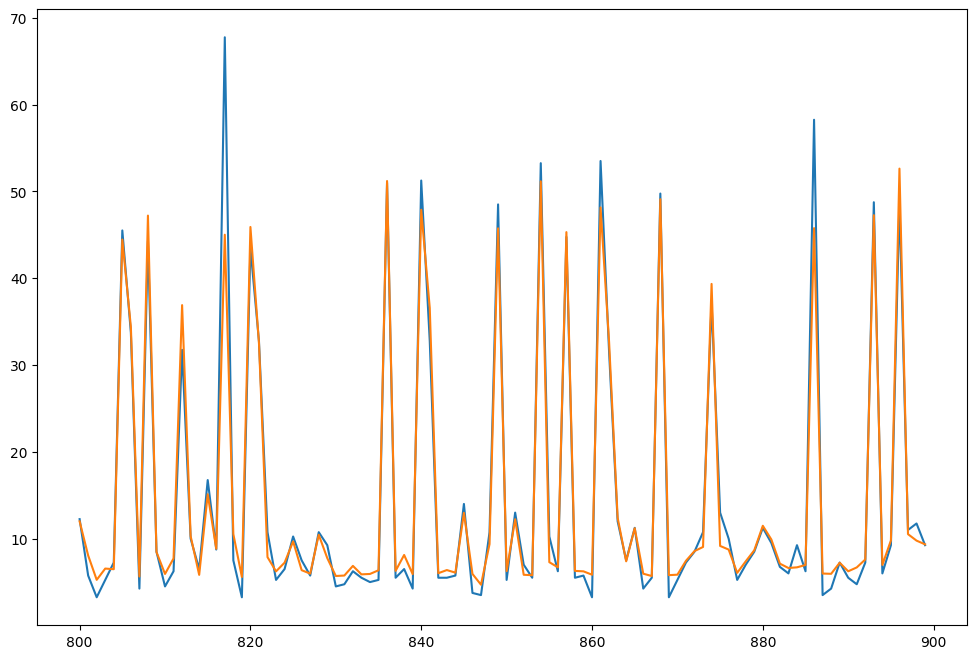

In [42]:
plt.figure(figsize=(12,8))
plt.plot(df_test_tuned_rf['Actual test'][800:900], label="A. Test")
plt.plot(df_test_tuned_rf['Prediction'][800:900], label="prediction")
plt.show()

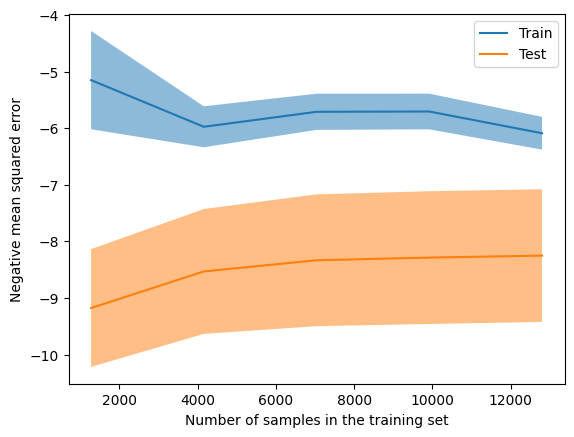

In [43]:
LearningCurveDisplay.from_estimator(rf_model_tuned, X_train, y_train, scoring='neg_mean_squared_error')
plt.show()